In [33]:
import matplotlib.pyplot as plt
import pymongo
import pandas as pd

from constants import *

In [82]:
client = pymongo.MongoClient('localhost', 27017)
db = client.mineral_db

In [98]:
minerals_in_pgm = {}

for x in db.mineral_coll.find():
    mineral = x['mineral_name']
    
    try:
        pgms = x['pgm']
    except:
        continue
        
    for pgm in pgms:
        if pgm in minerals_in_pgm.keys():
            minerals_in_pgm[pgm].append(mineral)
        else:
            minerals_in_pgm[pgm] = [ mineral ]

In [113]:
symmetry_indices = {
    'amorphous': 1,
    'triclinic': 2,
    'monoclinic': 4,
    'orthorhombic': 8,
    'trigonal': 12,
    'tetragonal': 16,
    'hexagonal': 24,
    'cubic': 48
}

pgm_symmetry_indices = {}
pgm_populations = {}
n_minerals_in_pgm = {}

for p in minerals_in_pgm.keys():
    pgm_pop = { cs: 0 for cs in symmetry_indices.keys() }
    num_minerals = 0
    pgm_sym_ind = 0
    
    for x in db.mineral_coll.find({ 'mineral_name': { '$in': minerals_in_pgm[p] } }):
        for crystal_system in x['crystal_systems']:
            if crystal_system in symmetry_indices.keys():
                pgm_pop[crystal_system] += 1
                num_minerals += 1
                pgm_sym_ind += symmetry_indices[crystal_system]
            
    try:
        pgm_symmetry_indices[p] = pgm_sym_ind / symmetry_indices['cubic'] / num_minerals
    except Exception as e:
        print(e)
        
    pgm_populations[p] = pgm_pop
    n_minerals_in_pgm[p] = num_minerals
    
pgm_symmetry_indices = { p: pgm_symmetry_indices[p] for p in sorted(pgm_symmetry_indices) }

float division by zero


In [115]:
pgm_attrs = pd.read_csv('data/2022_pgm_attributes.csv',
                        index_col='MODE'
                       ).transpose()
pgm_attrs.columns = [ s.lower() for s in pgm_attrs.columns ]

def get_attr(p, prop):
    if p[:-1] == 'p45':
        p = 'p45'
        
    if p[:-1] == 'p47':
        p = 'p47'
        
    return pgm_attrs[p][prop]


T_MIN = 'Temp (min) K'
T_MAX = 'Temp (max) K'
T_AVG = 'Temp (average) K'

P_MIN = 'P (min) log Pa'
P_MAX = 'P (max) log Pa'
P_AVG = 'P (average log Pa)'

In [134]:
def plot(ordering, name, n_plots=3, nums=False):
    fig, ax = plt.subplots(n_plots, figsize=(15, 30))
    l = len(ordering)//n_plots
    
    if len(ordering) % n_plots != 0:
        l += 1

    for i in range(n_plots):
        s, e = i*l, (i+1)*l

        r = len(ordering[s:e])
        bars = ax[i].bar(range(r), [ pgm_symmetry_indices[p] for p in ordering[s:e] ])
        ax[i].set_xticks(range(r), labels=ordering[s:e])
        ax[i].tick_params(axis='both', labelsize=FS_TICK)
        ax[i].set_title(f'Symmetry index of different paragenetic modes ({i+1}/{n_plots})', fontsize=FS_TITLE)

    # [ print(f'{p}:\t {sym:.3f}') for p, sym in pgm_symmetry_indices.items() ]

        if nums:
            for n_minerals, bar in zip([ n_minerals_in_pgm[p] for p in ordering[s:e] ], bars):
                ax[i].text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                           f'{n_minerals}',
                           ha='center', va='bottom', fontsize=FS_SAMPLE
                          )

    plt.savefig(f'results/{name}.png')
    
default_ordering = list(pgm_symmetry_indices.keys())[1:]

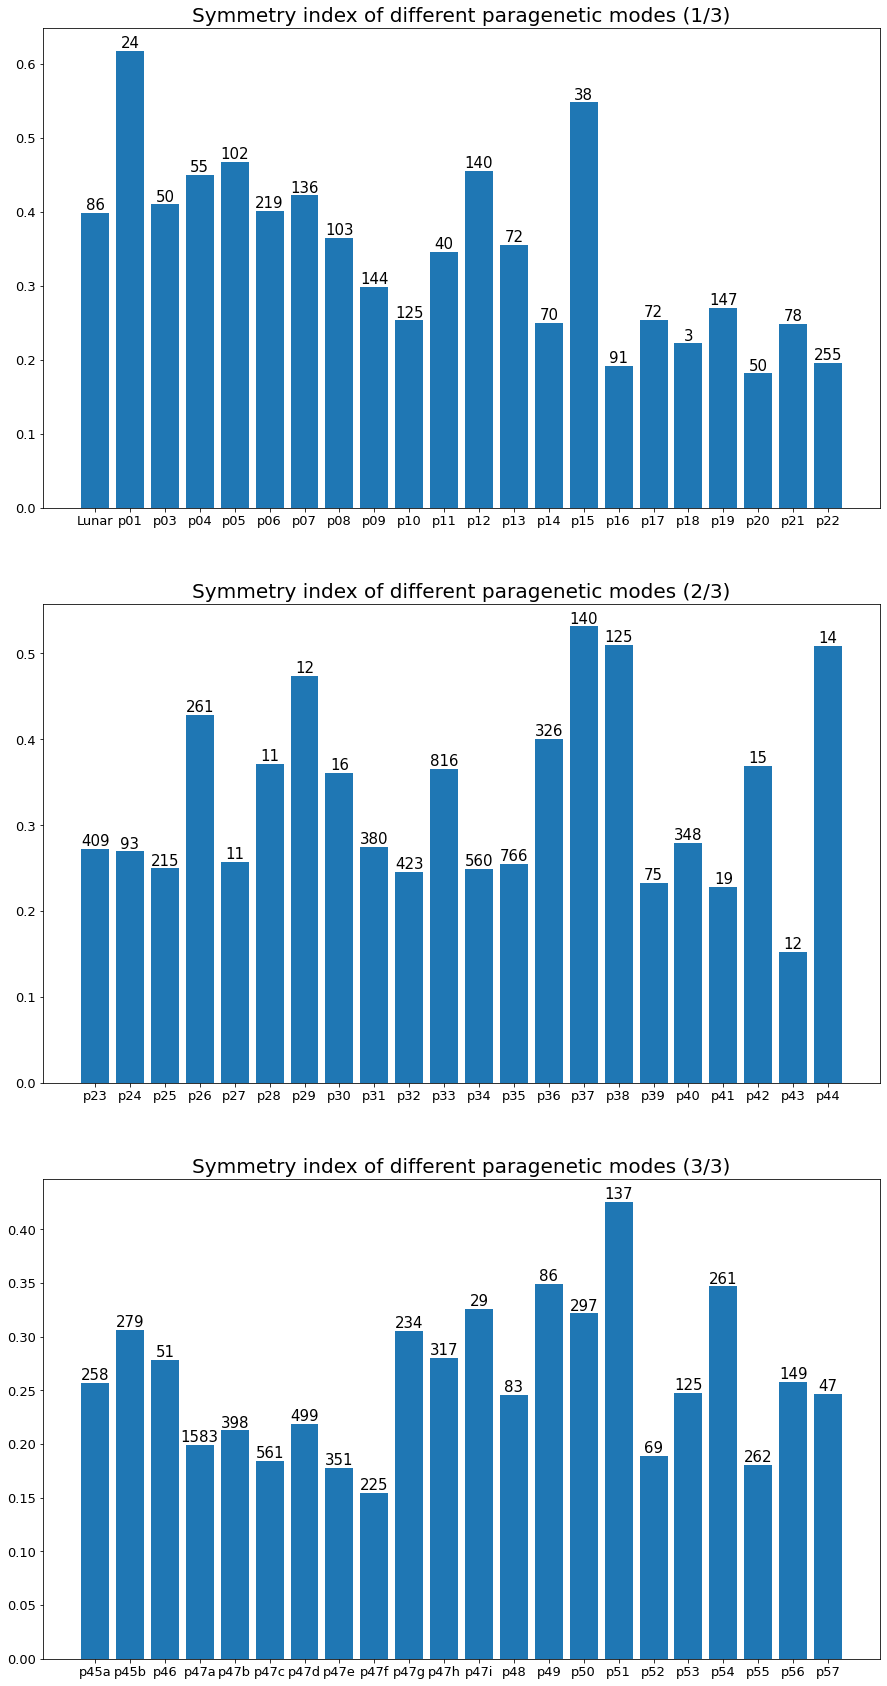

In [135]:
plot(['Lunar'] + default_ordering, 'graph_pgm', nums=True)

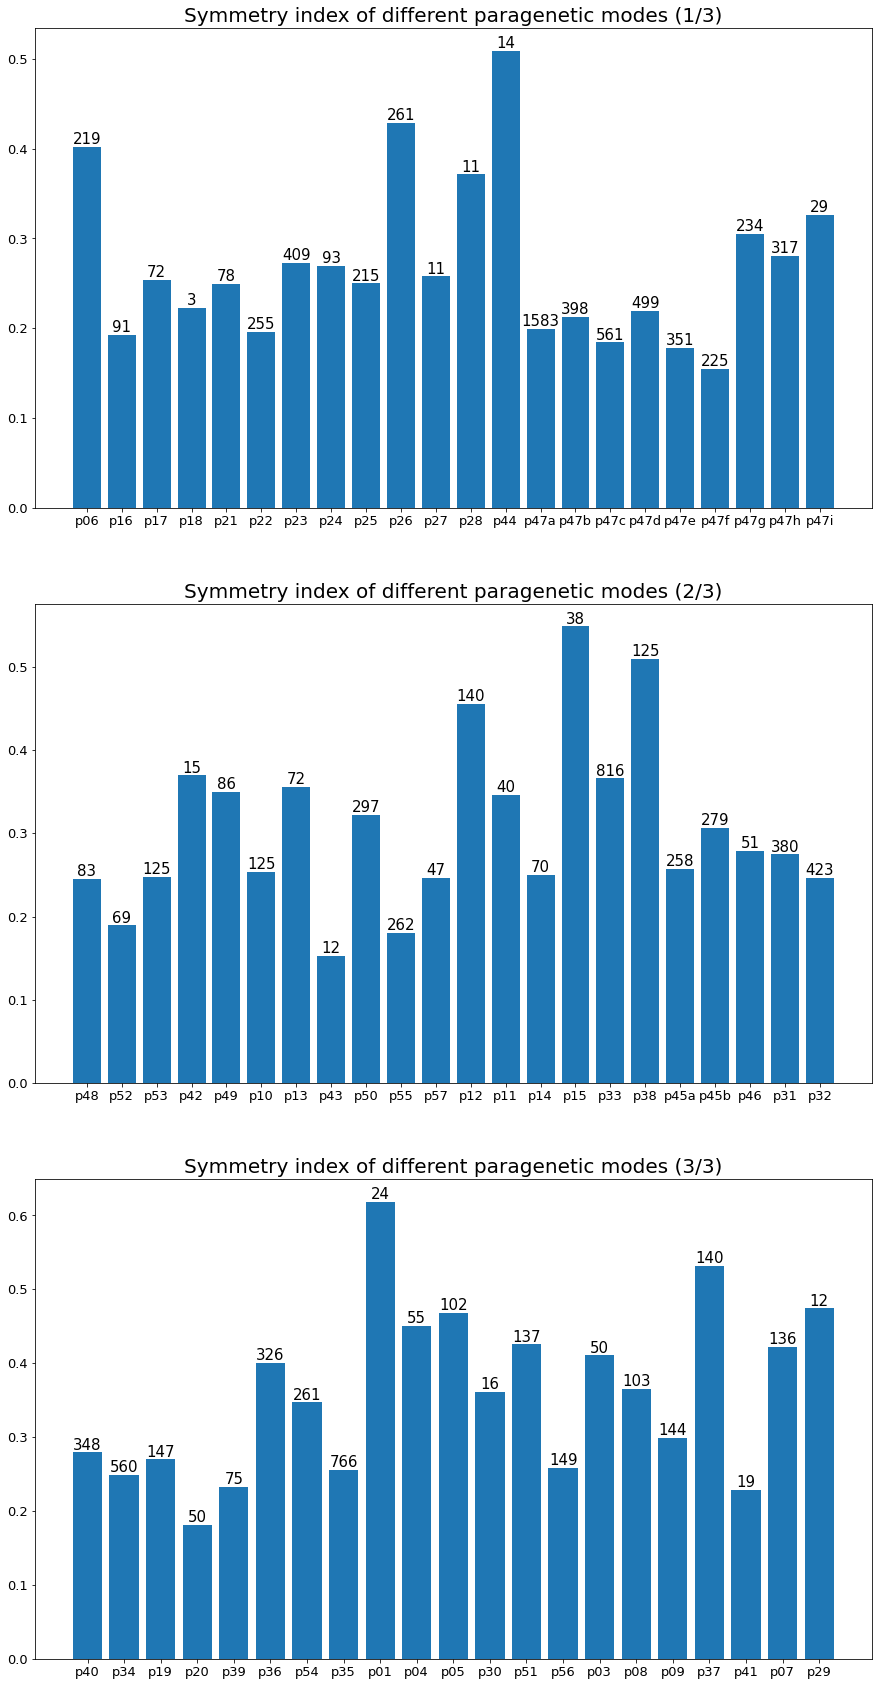

In [136]:
t_min_ordering = sorted(default_ordering, key=lambda p: get_attr(p, T_MIN))
plot(t_min_ordering, 'graph_pgm_tmin', nums=True)

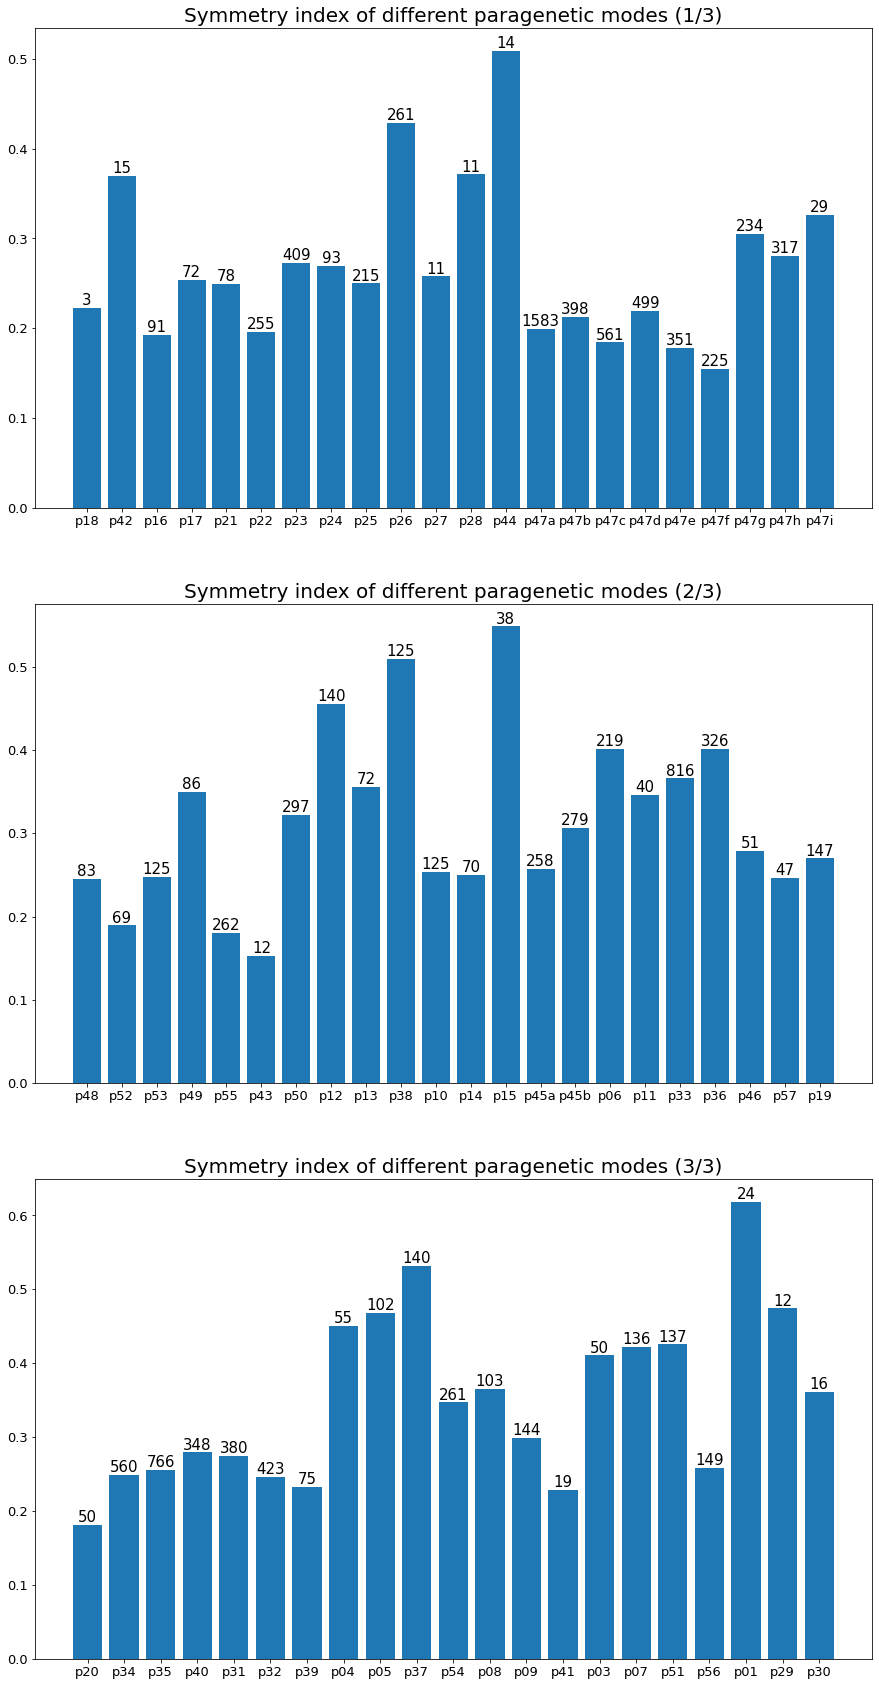

In [137]:
t_max_ordering = sorted(default_ordering, key=lambda p: get_attr(p, T_MAX))
plot(t_max_ordering, 'graph_pgm_tmax', nums=True)

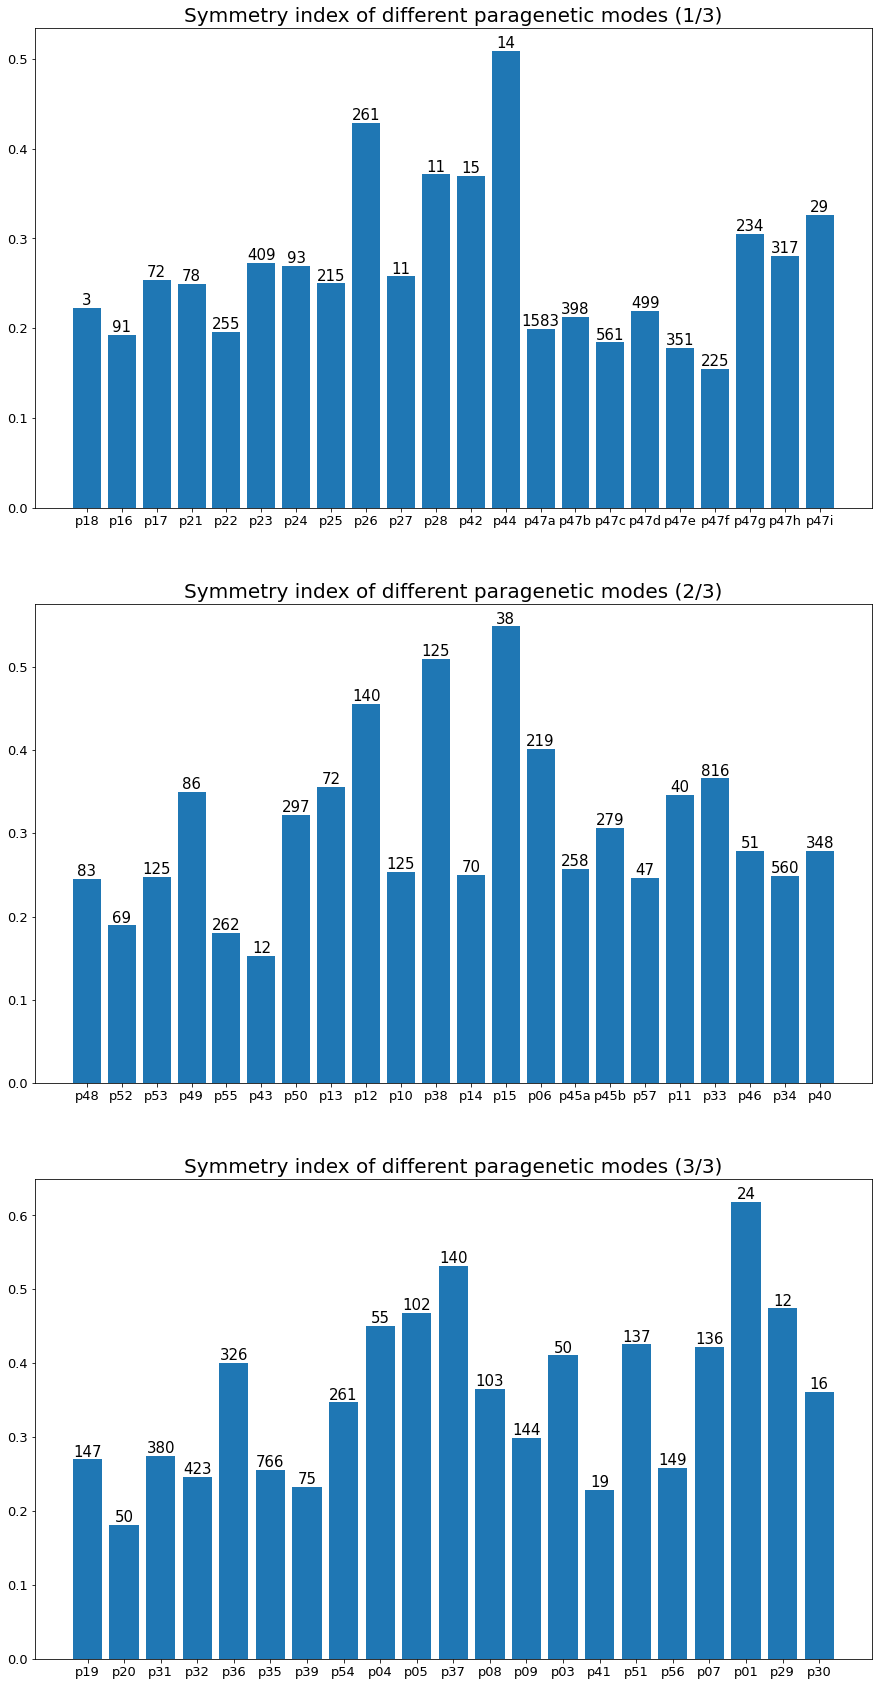

In [138]:
t_avg_ordering = sorted(default_ordering, key=lambda p: get_attr(p, T_AVG))
plot(t_avg_ordering, 'graph_pgm_tavg', nums=True)

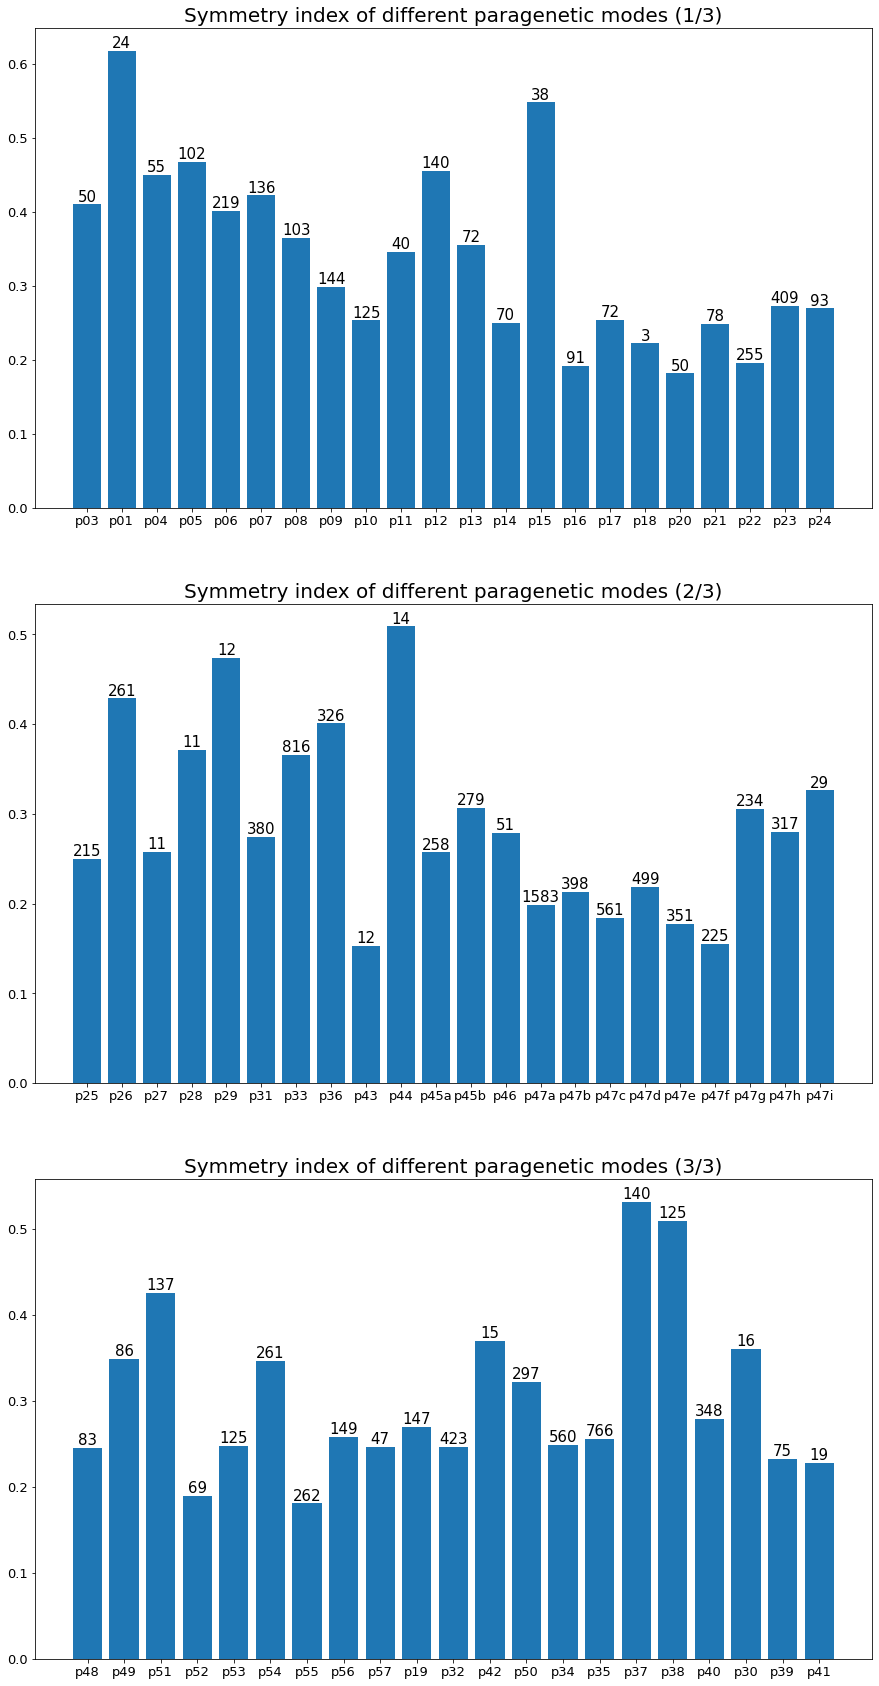

In [139]:
p_min_ordering = sorted(default_ordering, key=lambda p: get_attr(p, P_MIN))
plot(p_min_ordering, 'graph_pgm_pmin', nums=True)

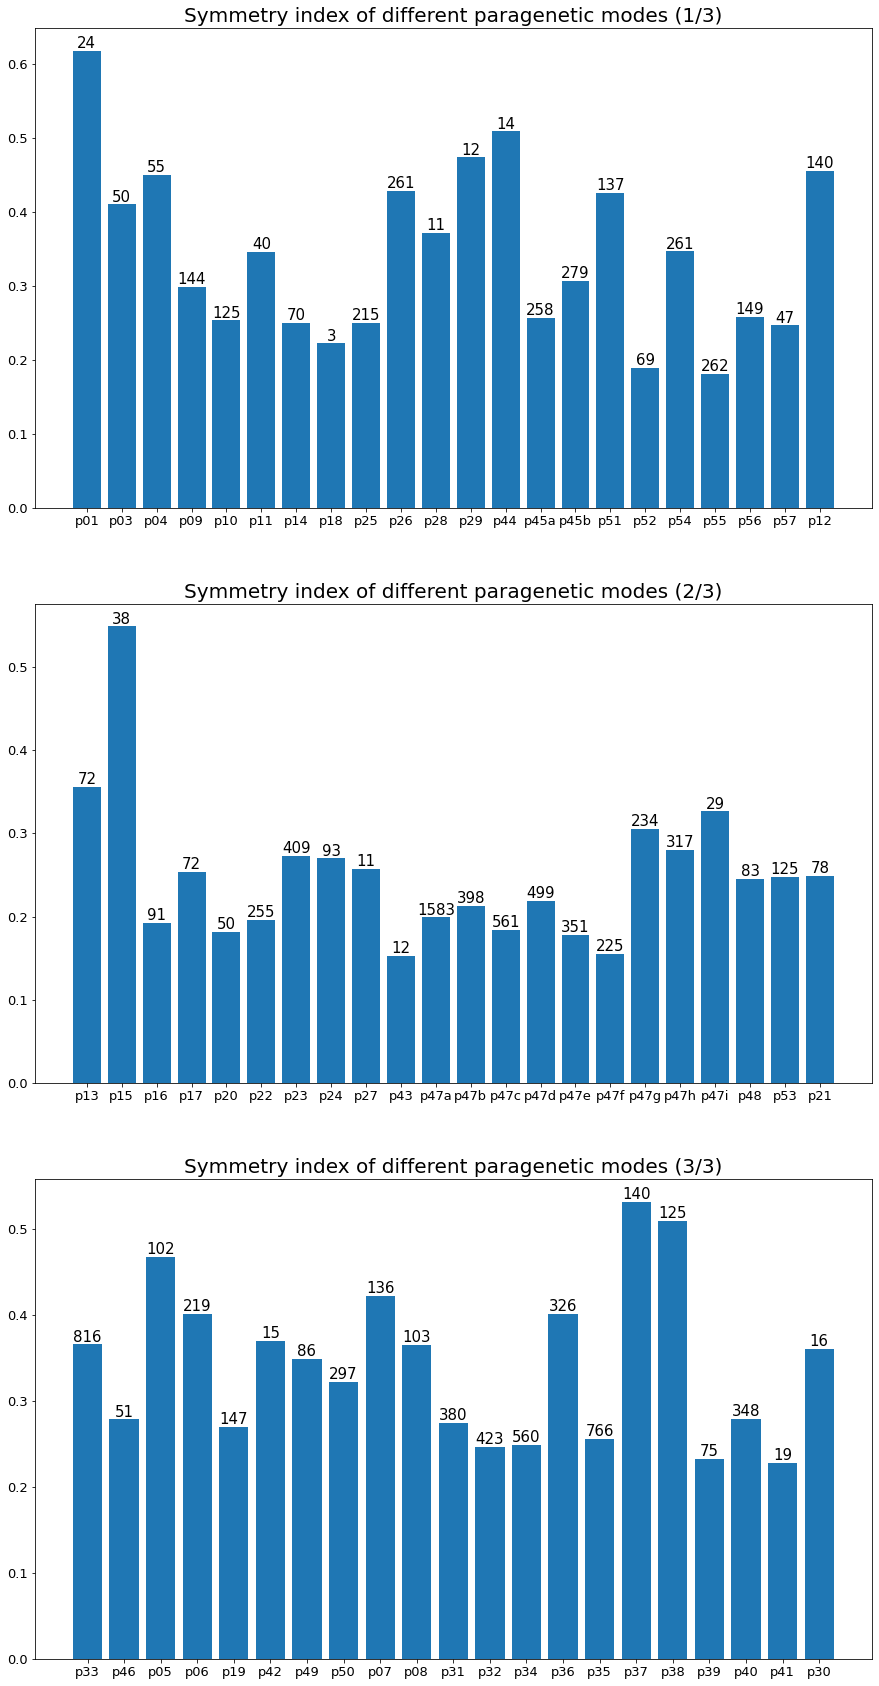

In [140]:
p_max_ordering = sorted(default_ordering, key=lambda p: get_attr(p, P_MAX))
plot(p_max_ordering, 'graph_pgm_pmax', nums=True)

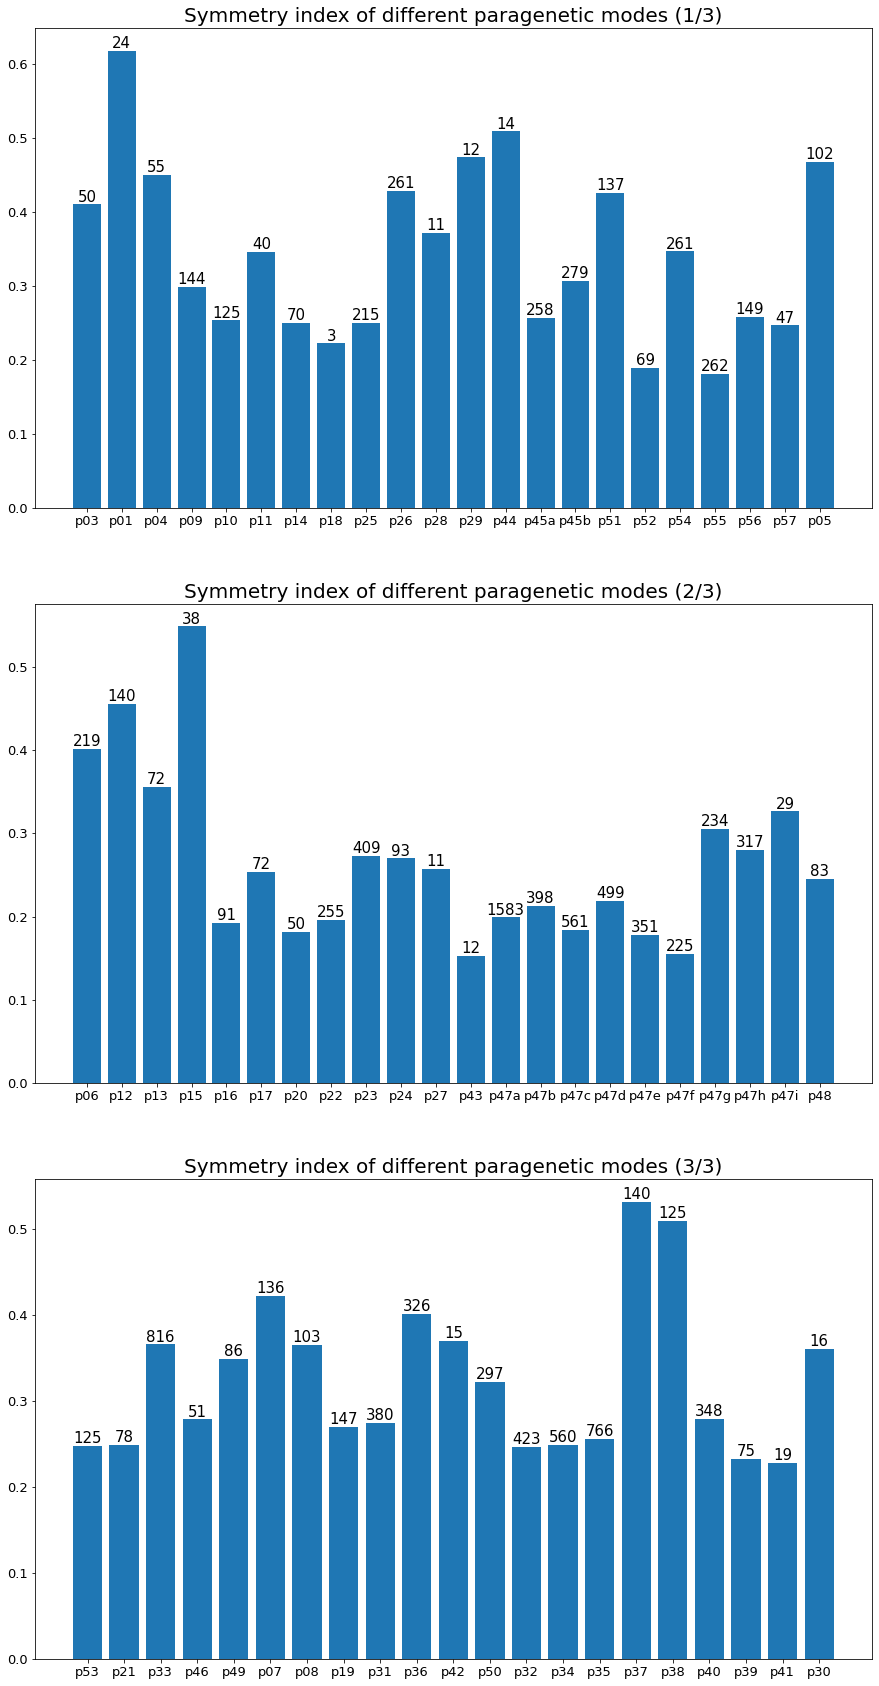

In [141]:
p_avg_ordering = sorted(default_ordering, key=lambda p: get_attr(p, P_AVG))
plot(p_avg_ordering, 'graph_pgm_pavg', nums=True)